### -

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
import mlflow
import mlflow.sklearn
import optuna
from random import randint
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
# Base Models (+ ST assessor)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC#, SVR # kernels: 'linear', 'poly' e 'rbf'
from sklearn.neural_network import MLPClassifier
from kan import KANClassifier
from sklearn.ensemble import RandomForestClassifier#, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import json

with open('config.json', 'r') as f:
    CONFIG = json.load(f)

In [4]:
from train_models import *

In [5]:
def load_all_models(experiments:str|list, model_names:list=CONFIG['BASE_MODELS']) -> dict:
    models = {}

    if(isinstance(experiments, str)):
        experiments = [experiments]*len(model_names)
    else:
        if(len(experiments) != len(model_names)):
            raise ValueError('Variável "experiments" deve ser uma lista com tamanho igual à "models", ou ser apenas uma string')

    for i in range(len(model_names)):
        trained_model, _ = load_model_by_name(experiments[i], model_names[i])
        models[model_names[i]] = trained_model

    return models

In [6]:
from sklearn.pipeline import NotFittedError

class Pool():
    def __init__(self, models):
        self.predictors = models
        #self.keys = list(models.keys())
        #self.predict_cache = None
        #self.predict_proba_cache = None
        self.tree_based = ['Decision_Tree','Random_Forest','Gradient_Boosting','AdaBoost','XGBoost']
    
    def __len__(self):
        return len(self.predictors)

    def fit(self, X, X_norm, y):
        for name, model in self.predictors.items():
            try:
                _ = model.predict(X)
            except NotFittedError:
                if(name in self.tree_based):
                    model.fit(X,y)
                else:
                    model.fit(X_norm,y)
            print(f'{name} fitted.')
        
        return self

    def predict(self, X, X_norm):
        pred = pd.DataFrame(columns=list(self.predictors.keys()))
        for name, model in self.predictors.items():
            if(name in self.tree_based):
                pred[name] = model.predict(X)
            else:
                pred[name] = model.predict(X_norm)
        return pred

    def predict_proba(self, X, X_norm):
        pred = {}
        for name, model in self.predictors.items():
            if(name in self.tree_based):
                pred[name] = model.predict_proba(X)
            else:
                pred[name] = model.predict_proba(X_norm)
        return pred
    
    def drop(self, *args):
        new_models = {}
        for name, model in self.predictors.items():
            if(name not in args):
                new_models[name] = model
        newPool = Pool(new_models)
        return newPool

#class PoolRejector():
#    def __init__(self):
#        pass

In [7]:
from math import floor
from scipy import stats as st

class Rejector():
    def __init__(self, model_pool:Pool):
        self.predictors = model_pool
        self.cache_input = None
        self.cache_output_preds = None
        self.cache_output_proba = None

    def predictWithReject(self, X, X_norm, reject_rate, reject_method:str='avg', warnings:bool=True):
        # reject_method deve ser igual a 'avg', 'median', 'min' ou 'max'
        if(reject_method not in ['avg', 'mean', 'median', 'min','max']):
            raise ValueError("reject_method deve ser igual a 'avg', 'mean, 'median', 'min' ou 'max'")
        
        if(isinstance(X, pd.DataFrame)):
            X = X.to_numpy()
        if((self.cache_input is not None) and (X.shape == self.cache_input.shape) and ((X == self.cache_input).all() and (self.cache_output_proba.shape[1]==len(self.predictors)))):
            predictions = self.cache_output_preds
            poolProb = self.cache_output_proba
        else:
            poolProb = pd.DataFrame()
            poolPreds = pd.DataFrame()
            results = self.predictors.predict_proba(X, X_norm)

            for name, probas in results.items():
                poolPreds[name] = np.argmax(probas, axis=1)
                poolProb[name] = 1 - np.max(probas, axis=1)

            predictions = pd.DataFrame(np.array(st.mode(poolPreds.values, axis=1))[0])

            self.cache_input = X
            self.cache_output_preds = predictions
            self.cache_output_proba = poolProb

        if(reject_method=='max'):
            predictions['score'] = poolProb.apply(lambda x: max(x), axis=1)
        elif(reject_method=='median'):
            predictions['score'] = poolProb.apply(lambda x: np.median(x), axis=1)
        elif(reject_method=='min'):
            predictions['score'] = poolProb.apply(lambda x: min(x), axis=1)
        else: #avg or mean
            predictions['score'] = poolProb.apply(lambda x: np.mean(x), axis=1)

        if(reject_rate > 1):
            reject_rate = reject_rate/100

        n_reject = floor(poolProb.shape[0] * reject_rate)
        if((n_reject==0) and (warnings)):
            print('Warning: Number of rejections equals 0. Increase the rejection rate.')
        elif((n_reject==poolProb.shape[0]) and (warnings)):
            print('Warning: All examples will be rejected. Decrease the rejection rate.')

        predictions = predictions.sort_values(by='score', ascending=False)
        predictions.iloc[:n_reject, :] = np.nan # REJECTED
        predictions = predictions.drop(columns=['score']).sort_index()

        return predictions[0]

In [8]:
def rejection_overhall(rejector, x, x_norm, y, rej_rates, methods=['avg','median','min','max']):
    results_log = pd.DataFrame(columns=['Method','Rejection Rate','Accuracy','Precision','Recall','F1-Score'])
    rejection_history = pd.DataFrame(columns=['idx','Method','Rejection Rate'])
    #rejected = {}
    rej_rates = np.asarray(rej_rates)
    if(any(rej_rates<0) or any(rej_rates>1)):
        raise ValueError("Apenas valores entre 0 e 1")
    if(rej_rates.max() != 1):
        rej_rates = np.append(rej_rates, [1])
    
    total_iterations = len(methods) * len(rej_rates)

    with tqdm(total=total_iterations, desc="Processing") as pbar:
        for method in methods:
            for reject_rate in rej_rates:
                y_pred = rejector.predictWithReject(x, x_norm, reject_rate, method, warnings=False)
                idx = y_pred.dropna().index
                
                idx_rej = y_pred[y_pred.isna()].index
                rejected = rejection_history.loc[rejection_history['Method']==method,'idx']
                idx_rej = list(set(idx_rej) - set(rejected))
                for i in range(len(idx_rej)):
                    rejection_history.loc[rejection_history.shape[0],:] = [idx_rej[i], method, reject_rate]
                
                if(reject_rate!=1):
                    acc = accuracy_score(y[idx], y_pred[idx])
                    if(len(set(y))>2):
                        pre = precision_score(y[idx], y_pred[idx], zero_division=0, average='macro')
                        rec = recall_score(y[idx], y_pred[idx], zero_division=0, average='macro')
                        f1s = f1_score(y[idx], y_pred[idx], zero_division=0, average='macro')
                    else:
                        pre = precision_score(y[idx], y_pred[idx], zero_division=0)
                        rec = recall_score(y[idx], y_pred[idx], zero_division=0)
                        f1s = f1_score(y[idx], y_pred[idx], zero_division=0)
                    results_log.loc[results_log.shape[0]] = [method,reject_rate,acc,pre,rec,f1s]
                    
                pbar.set_postfix({'Method': method, 'Rate': f'{reject_rate:.2f}'})
                pbar.update(1)

    return results_log, rejection_history

In [9]:
color_palette = sns.color_palette("viridis_r", as_cmap=True)

- **Versões:**
  - v0: Versão inicial. Sem assessores. Apenas cálculo de confiança para rejeição por meio da probabilidade de classe dos modelos.

# TWO MOONS

In [16]:
#from train_models import experiment_name

experiment_name = getExpName('twomoons')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/494908295467387025', creation_time=1759707535932, experiment_id='494908295467387025', last_update_time=1759707535932, lifecycle_stage='active', name='twomoons_v0_1246495320', tags={}>

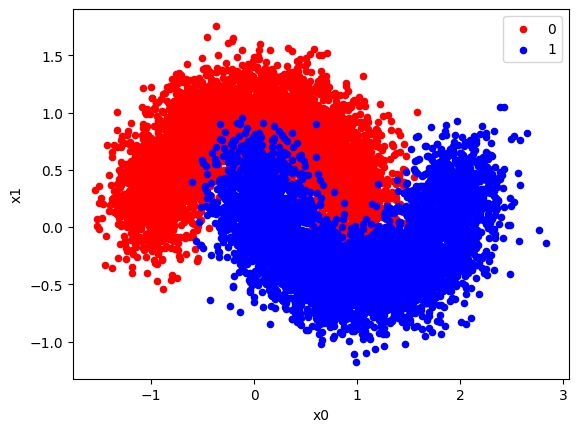

In [17]:
# generate 2d classification dataset
X, y = make_moons(n_samples=CONFIG['TWO_MOONS']['N_SAMPLES'], 
                  noise=CONFIG['TWO_MOONS']['NOISE'], 
                  random_state=CONFIG['SEED'])
df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [18]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

937a626718cd4a9f80529c1aa5a49a11


3977094c807a417b90e947f9bb3ef35f


81fbbd13b2304d2f87a9ce4813ff0e9f


330bc02845f148788f1447fc74f84843


081ad4a8935649918e70027ba965da1d


5b66802190ec435196842f88905f9ee7


4957b9df8f40411d8bfca7a2e72e056c


77203a99e6484c18a331f89c8dde817b


4e2c1460d7134cc090f47db3917c9b38


4581e75635e5404ca6cc79d0b1c8b10c


8634629504dd41bf9cdf22cfb76d9df7


f3150119303b475181e4f9964d95e692


In [19]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('twomoons')

In [20]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [21]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,#[:1500],
                                                 X_test_norm,#[:1500],
                                                 y_test,#[:1500],
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 80/80 [00:07<00:00, 11.02it/s, Method=max, Rate=1.00]   


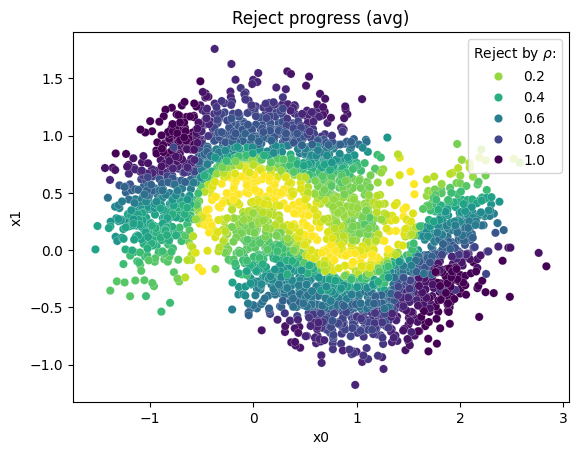

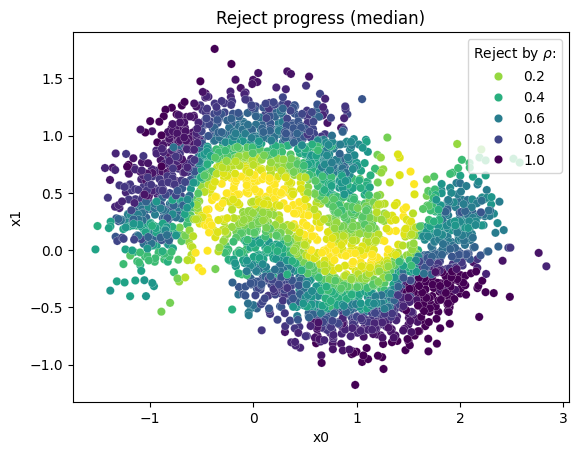

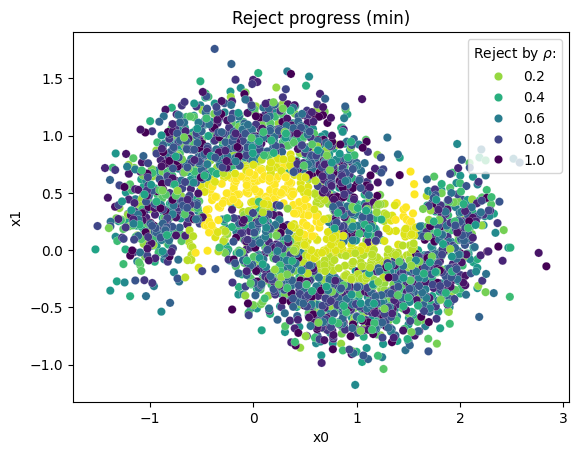

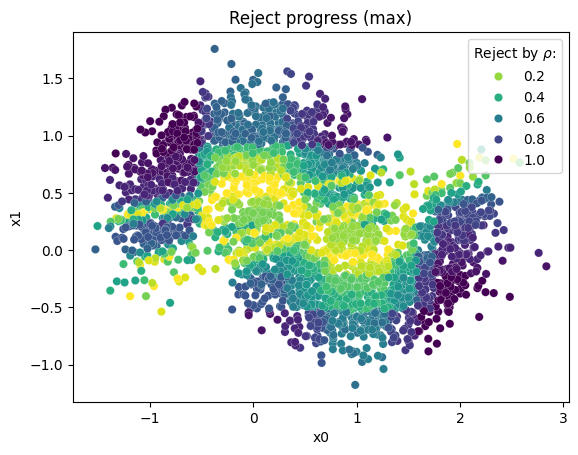

In [23]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste.sort_index(ascending=False), x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

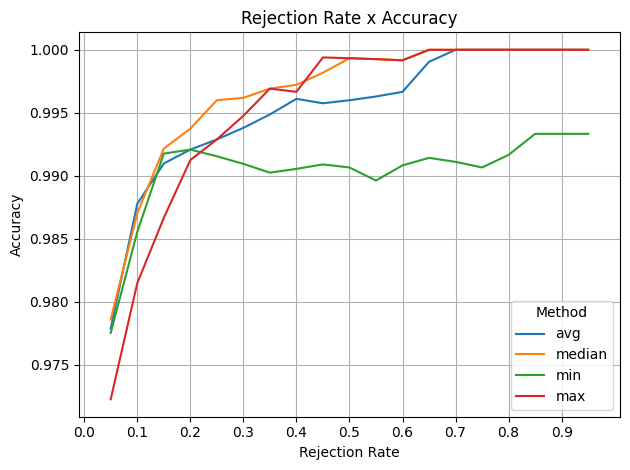

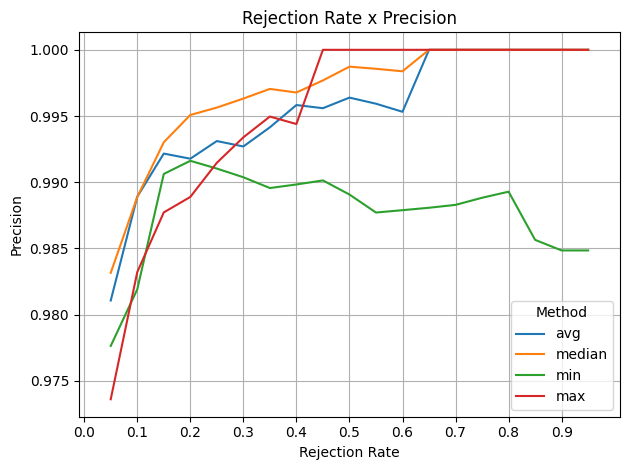

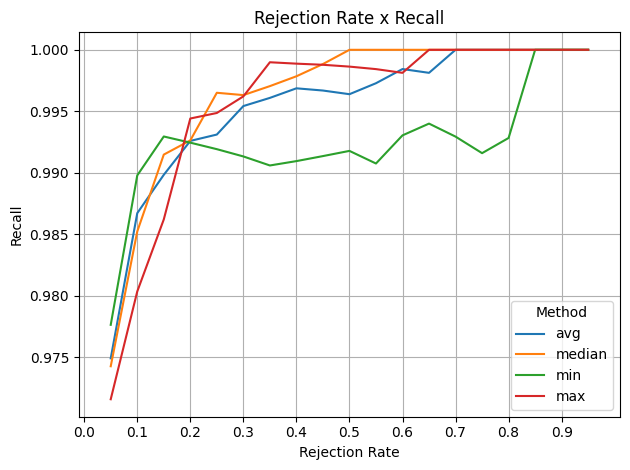

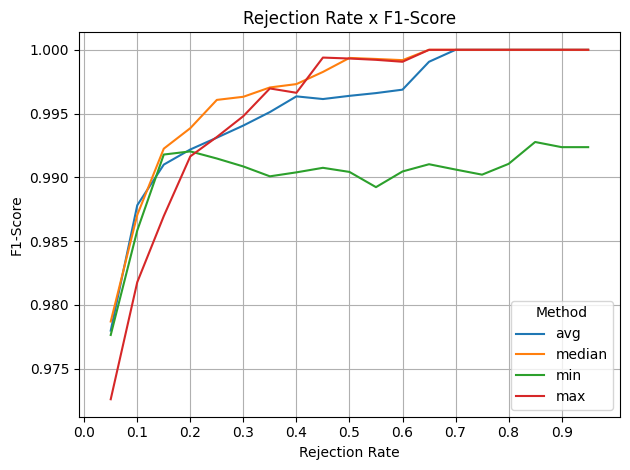

In [24]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [25]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.896
Method: median 	 |  Score: 0.897
Method: min 	 |  Score: 0.892
Method: max 	 |  Score: 0.896


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.977895   0.981066  0.974913  0.977980  0.896062
1     avg            0.10  0.987778   0.988905  0.986716  0.987809  0.896062
2     avg            0.15  0.990980   0.992163  0.989836  0.990998  0.896062
3     avg            0.20  0.992083   0.991776  0.992593  0.992184  0.896062
4     avg            0.25  0.992889   0.993109  0.993109  0.993109  0.896062
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  1.000000   1.000000  1.000000  1.000000  0.896197
72    max            0.80  1.000000   1.000000  1.000000  1.000000  0.896197
73    max            0.85  1.000000   1.000000  1.000000  1.000000  0.896197
74    max            0.90  1.000000   1.000000  1.000000  1.000000  0.896197
75    max            0.95  1.000000   1.000000  1.000000  1.000000  0.896197

[76 rows x 7 columns]

In [228]:
results_log.to_csv('results/twomoons_V0.csv')

# CIRCLES

In [229]:
#from train_models import experiment_name

experiment_name = getExpName('circles')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/176240900034942238', creation_time=1761054139569, experiment_id='176240900034942238', last_update_time=1761054139569, lifecycle_stage='active', name='circles_v0_1246495320', tags={}>

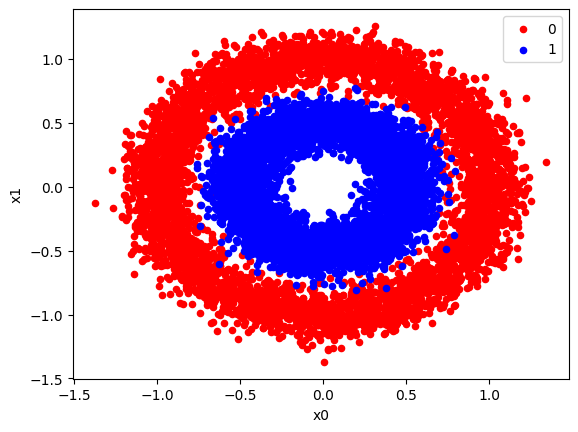

In [230]:
X, y = make_circles(n_samples=int(CONFIG['CIRCLES']['N_SAMPLES']/1), 
                            noise=CONFIG['CIRCLES']['NOISE'], 
                            factor=CONFIG['CIRCLES']['FACTOR'],
                            random_state=CONFIG['SEED'])

df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [231]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

865188b0261944d793cdf0498d361b9f


ef02d282cb4d40319ba4377dff7bb0da


83e6b099baac48d79ac7643ce73694f9


69926aa6dc2c4795871f2ea72127398d


86908d7fe54a474cb233766b9a8d01f8


5469993a3dfa469eb2cddecff60368f5


6eb0aa153584430bad70324b2e915f0f


d810ec65dda641a0bd2396fa4326d094


3b1187244862432dbeaa083e81d2c124


a9451bef3b554924b8c5115cfb0624a3


9096ac19b4e24ff5adff1800d6a28461


d0eea025a64f4c12b59b5a1842650dd0


In [232]:
X_train_c, X_train_norm_c, X_test_c, X_test_norm_c, y_train_c, y_test_c = get_data('circles')

modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [239]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test_c,#[:500],
                                                 X_test_norm_c,#[:500],
                                                 y_test_c,#[:500],
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 80/80 [00:10<00:00,  7.69it/s, Method=max, Rate=1.00]   


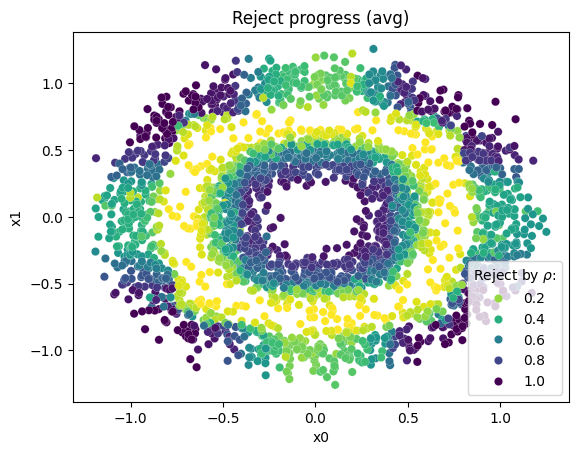

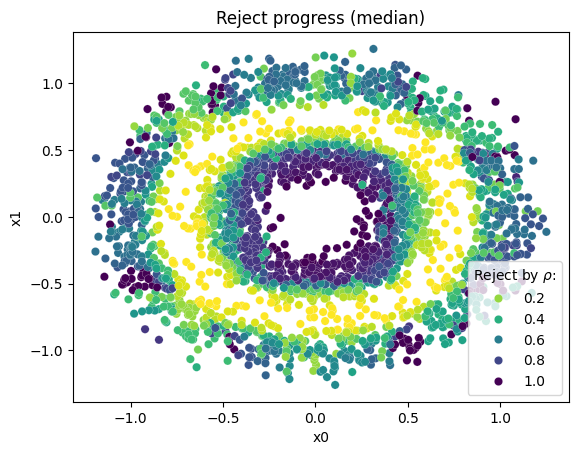

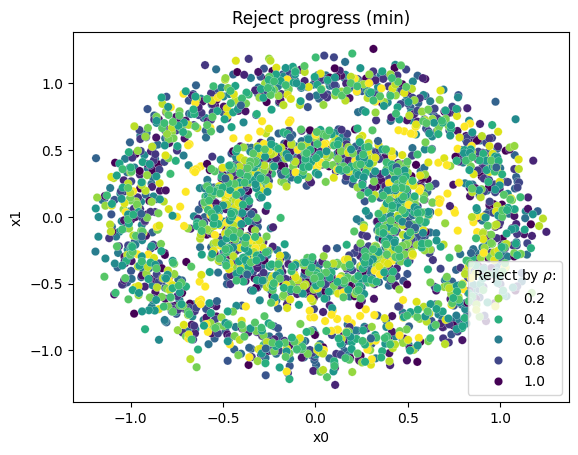

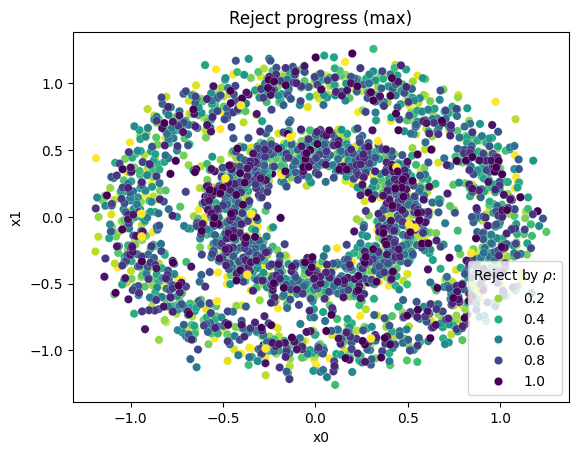

In [240]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test_c), pd.Series(y_test_c), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste, x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

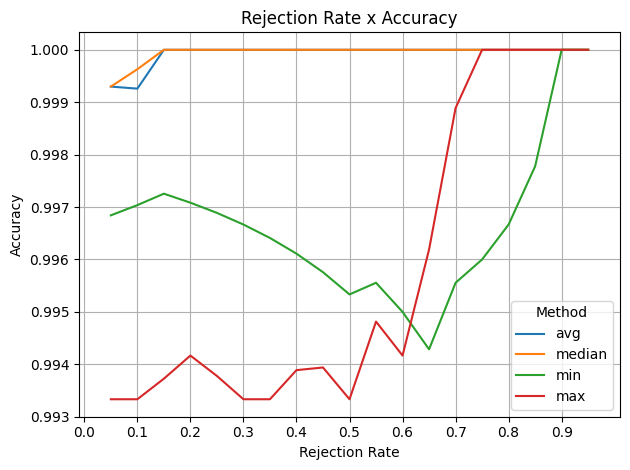

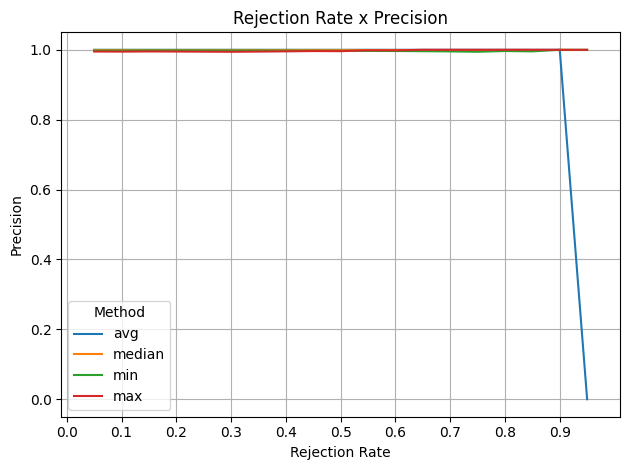

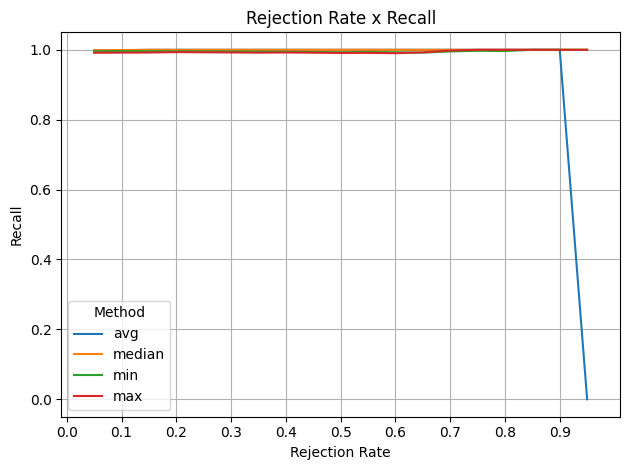

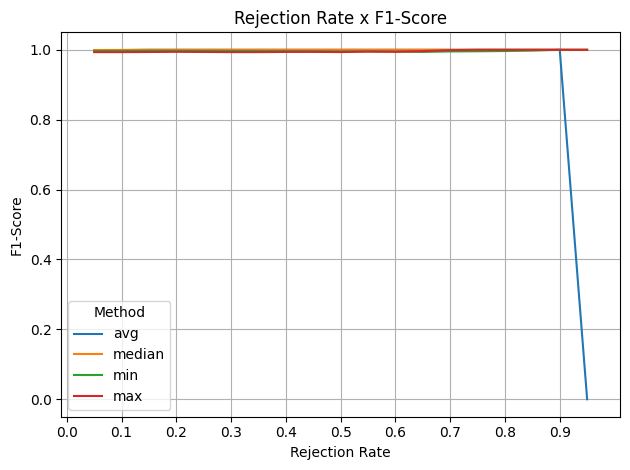

In [241]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [242]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.900
Method: median 	 |  Score: 0.900
Method: min 	 |  Score: 0.897
Method: max 	 |  Score: 0.896


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.999298        1.0  0.998601  0.999300  0.899945
1     avg            0.10  0.999259        1.0  0.998519  0.999259  0.899945
2     avg            0.15  1.000000        1.0  1.000000  1.000000  0.899945
3     avg            0.20  1.000000        1.0  1.000000  1.000000  0.899945
4     avg            0.25  1.000000        1.0  1.000000  1.000000  0.899945
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  1.000000        1.0  1.000000  1.000000  0.896178
72    max            0.80  1.000000        1.0  1.000000  1.000000  0.896178
73    max            0.85  1.000000        1.0  1.000000  1.000000  0.896178
74    max            0.90  1.000000        1.0  1.000000  1.000000  0.896178
75    max            0.95  1.000000        1.0  1.000000  1.000000  0.896178

[76 rows x 7 columns]

In [243]:
results_log.to_csv('results/circles_V0.csv')

# AIRBNB

In [244]:
experiment_name = getExpName('airbnb')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/504386116767894917', creation_time=1760128217330, experiment_id='504386116767894917', last_update_time=1760128217330, lifecycle_stage='active', name='airbnb_v0_1246495320', tags={}>

In [245]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('airbnb')

In [246]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

57307f00799a49f891c3d5879123be6c


337057925ba34619a9bb81ed2fcb7a94


cd14dd0a07ae4ed2b6a8e035da6dcdbe


6bf1f8b02dae4cfa90006313ae7e1b5b


78263e20a35d46ba93f9b0bed051a4ee


30c0c01ed88d4a67824e69945bdd0a32


489829756440401cb4b763f41c9c9c32


69bc02563ab24af08e6e40ac8dffaf90


07a98b2ace084e4f833b308deb38664c


f56a84af216040f798fd6a53c1245667


55a1b97aac0144d0822d1ff36b555fe9


6ba1b13dfb42492bb170a458c6efd127


In [247]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [252]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test.values,
                                                 X_test_norm.values,
                                                 y_test.values,
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 80/80 [00:27<00:00,  2.95it/s, Method=max, Rate=1.00]   


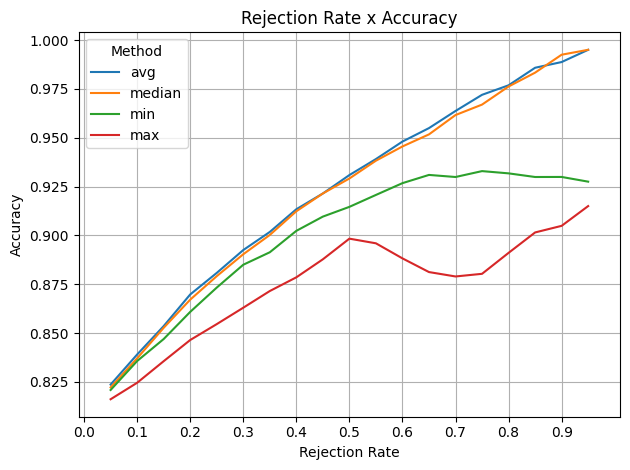

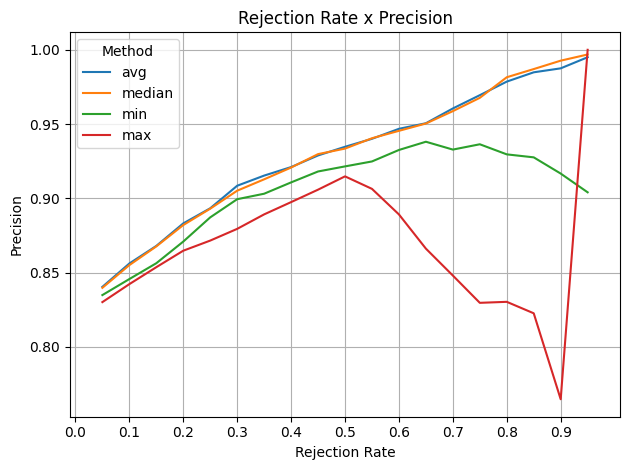

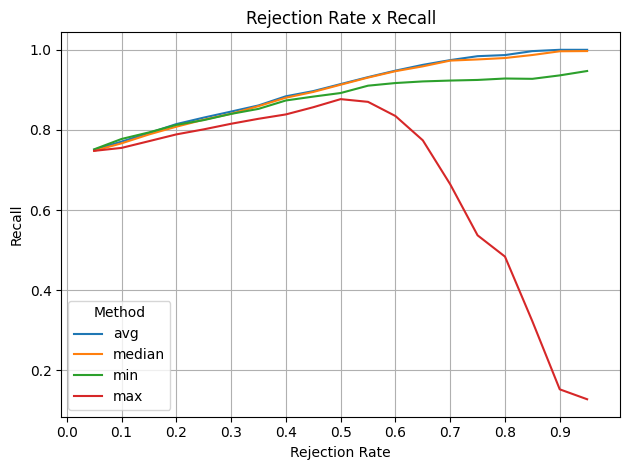

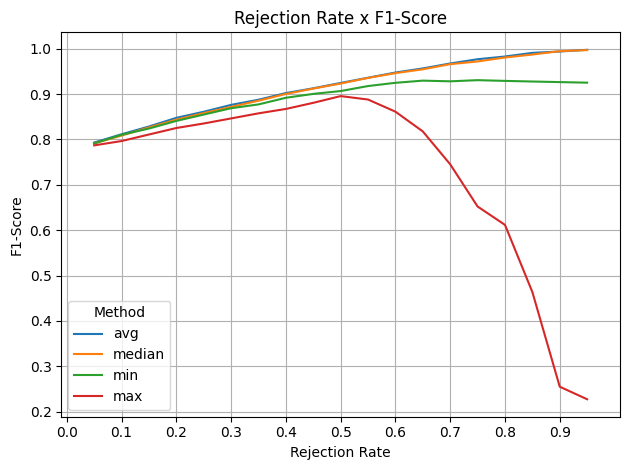

In [253]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [255]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.832
Method: median 	 |  Score: 0.831
Method: min 	 |  Score: 0.811
Method: max 	 |  Score: 0.787


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.823622   0.840380  0.750805  0.793071  0.832071
1     avg            0.10  0.839015   0.856110  0.770924  0.811287  0.832071
2     avg            0.15  0.853565   0.867945  0.792272  0.828384  0.832071
3     avg            0.20  0.869756   0.883117  0.814658  0.847507  0.832071
4     avg            0.25  0.880781   0.893290  0.830827  0.860927  0.832071
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  0.880320   0.829630  0.537170  0.652111  0.787393
72    max            0.80  0.891046   0.830303  0.484099  0.611607  0.787393
73    max            0.85  0.901503   0.822581  0.322785  0.463636  0.787393
74    max            0.90  0.904881   0.764706  0.152941  0.254902  0.787393
75    max            0.95  0.915000   1.000000  0.128205  0.227273  0.787393

[76 rows x 7 columns]

In [256]:
results_log.to_csv('results/airbnb_V0.csv')

# BLOBS

In [26]:
experiment_name = getExpName('blobs')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/965220660090511125', creation_time=1761101862380, experiment_id='965220660090511125', last_update_time=1761101862380, lifecycle_stage='active', name='blobs_v0_1246495320', tags={}>

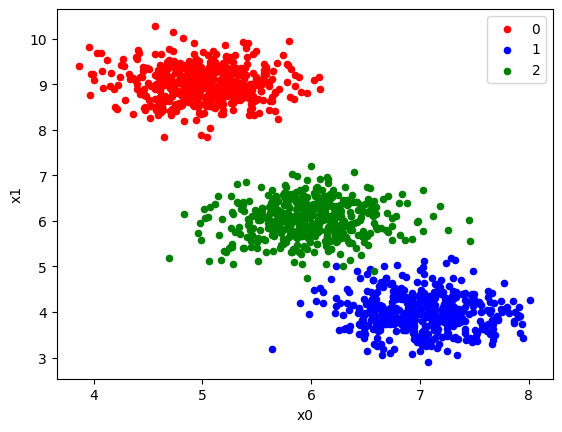

In [27]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('blobs')

df = pd.DataFrame(dict(x0=X_test[:,0], x1=X_test[:,1], label=y_test))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [28]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

8d15cee535794bb983eea8c602ed4b4d


6b6fe026c8e540959fab3a26eb35fb9c


26b4401f938542c8a21591e682a9f72f


4f706cd1c5824becb11fae9afa6c1c07


184abf29068b425085bac87bf6922f1d


708cddca3f554006ad522d8827b8cada


b41d4363ae71480f97f633982748ee43


af3cb9c4358349919f5e202bc707669a


65ccbb9fdaf947518a9a162c9173309b


4948c6adf68e4c64a1ab0cec5864ca0f


6fad1e55dacf4c228bdb3f906ca2f2cc


3a1bbfacfdf44198acca6e96ba79bcb3


In [29]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [30]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 X_test_norm,
                                                 y_test,
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 80/80 [00:03<00:00, 23.69it/s, Method=max, Rate=1.00]   


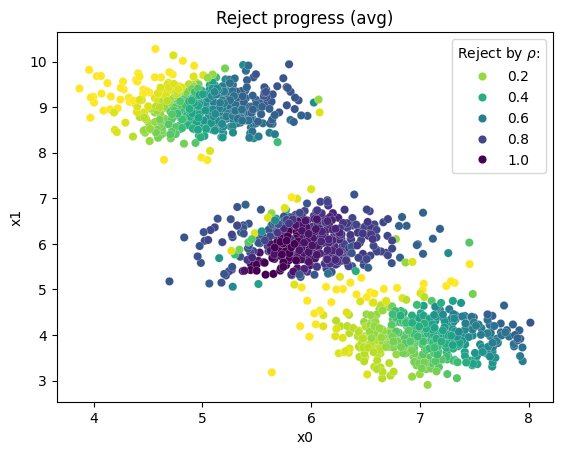

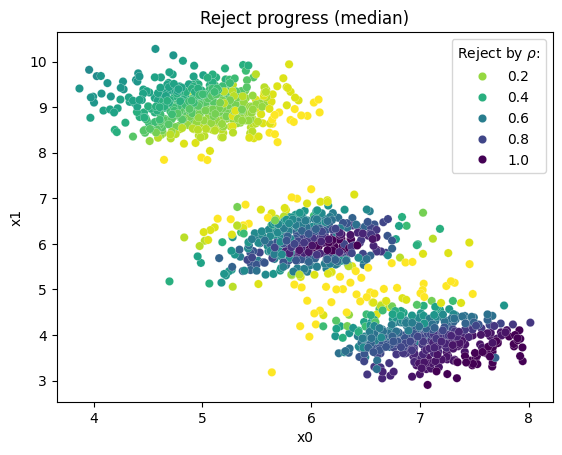

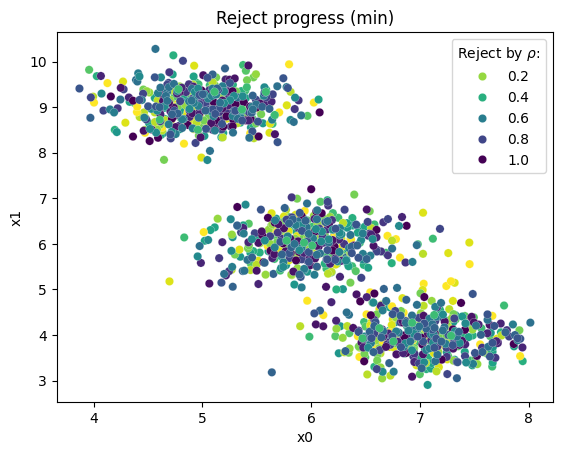

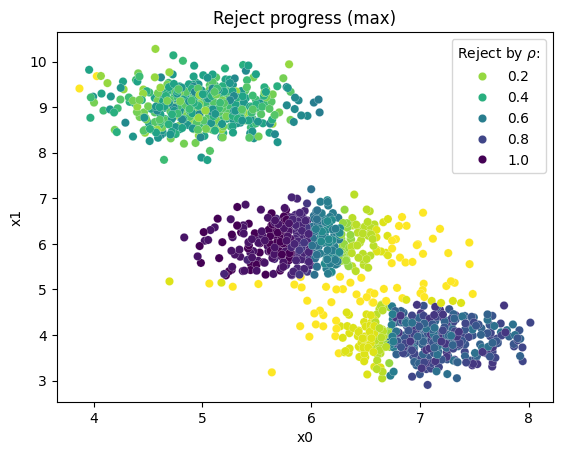

In [32]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste.sort_index(ascending=False), x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

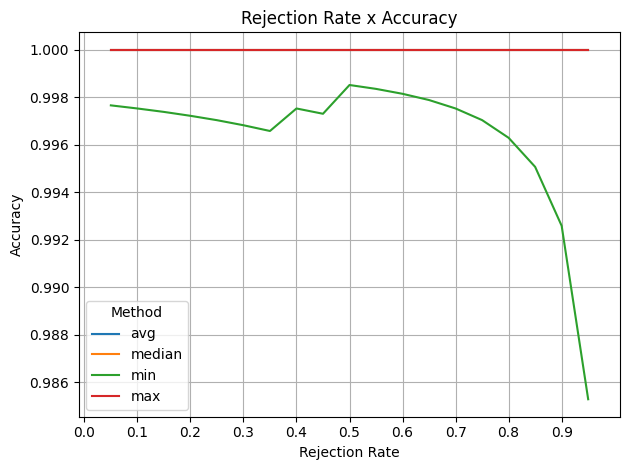

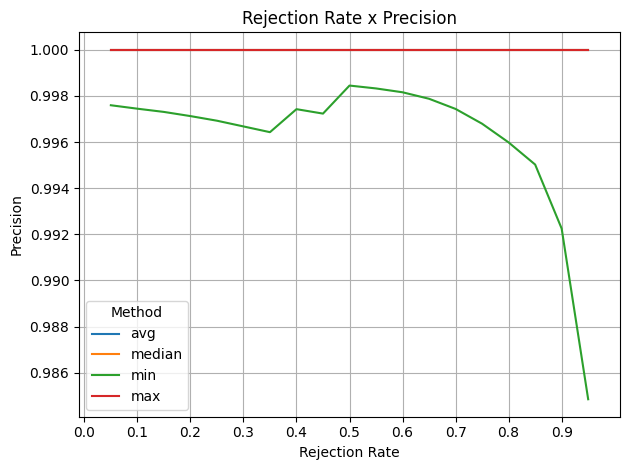

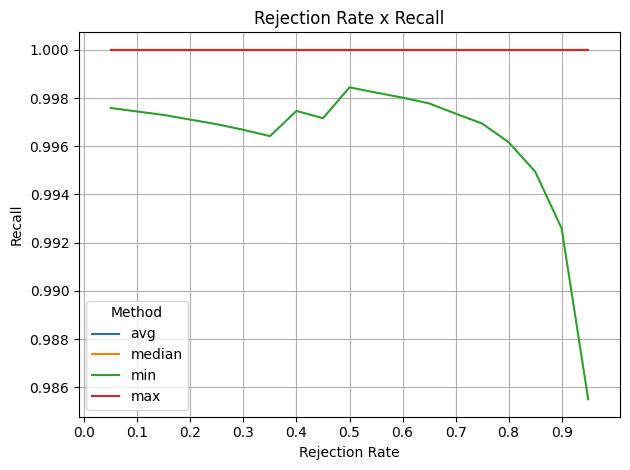

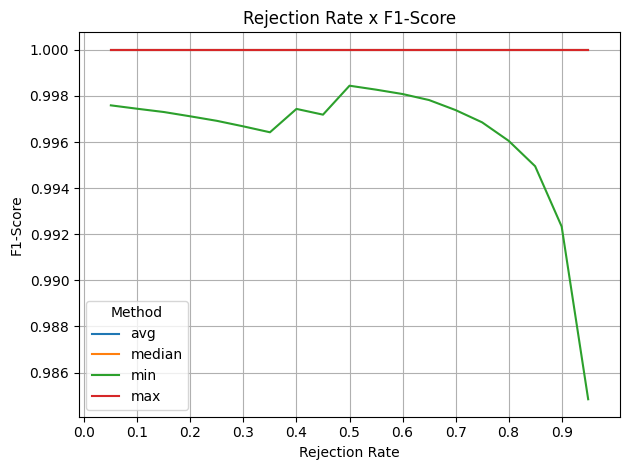

In [13]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [14]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.900
Method: median 	 |  Score: 0.900
Method: min 	 |  Score: 0.897
Method: max 	 |  Score: 0.900


Method  Rejection Rate  Accuracy  Precision  Recall  F1-Score  AU-ARC
0     avg            0.05       1.0        1.0     1.0       1.0     0.9
1     avg            0.10       1.0        1.0     1.0       1.0     0.9
2     avg            0.15       1.0        1.0     1.0       1.0     0.9
3     avg            0.20       1.0        1.0     1.0       1.0     0.9
4     avg            0.25       1.0        1.0     1.0       1.0     0.9
..    ...             ...       ...        ...     ...       ...     ...
71    max            0.75       1.0        1.0     1.0       1.0     0.9
72    max            0.80       1.0        1.0     1.0       1.0     0.9
73    max            0.85       1.0        1.0     1.0       1.0     0.9
74    max            0.90       1.0        1.0     1.0       1.0     0.9
75    max            0.95       1.0        1.0     1.0       1.0     0.9

[76 rows x 7 columns]

In [33]:
results_log.to_csv('results/blobs_V0.csv')

# ANISO

In [34]:
experiment_name = getExpName('aniso')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/341957655926090078', creation_time=1761102858606, experiment_id='341957655926090078', last_update_time=1761102858606, lifecycle_stage='active', name='aniso_v0_1246495320', tags={}>

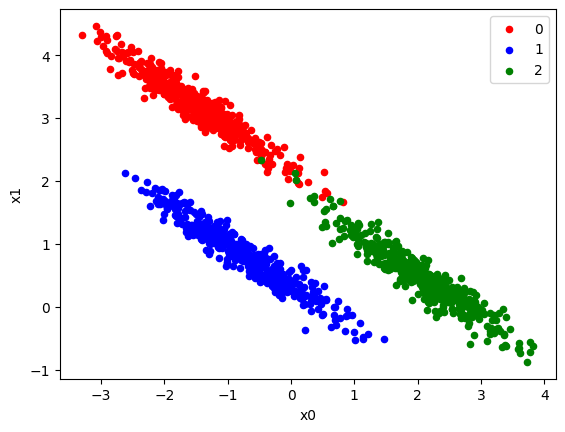

In [40]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('aniso')
df = pd.DataFrame(dict(x0=X_test[:,0], x1=X_test[:,1], label=y_test))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [36]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

347c404c9caf407aa373ed01c1abd4be


1755616bdb3546c6bc743ca9936bddae


bb8f9fce91cf41cba7670df0df2efda7


dcd46a46c62f43f6be8213e1240745b3


6ea87c58e7c2478194f2c4c6b8f6634c


72fde8b8967648a7aaa239457bcb68e3


0bcb952e51ef421da3db6243c65eb2bd


1861034e005e4774be1c71f2c186b8e2


4b88998ff6c54ddd94d1c2b6138c783a


cc319b47057b47918dddcba17adfc0e1


207e0507f58e45d1924fab9369b6c0db


3db7e48f40c0444e983c9cb5434689cf


In [43]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [44]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 X_test_norm,
                                                 y_test,
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 80/80 [00:03<00:00, 23.57it/s, Method=max, Rate=1.00]   


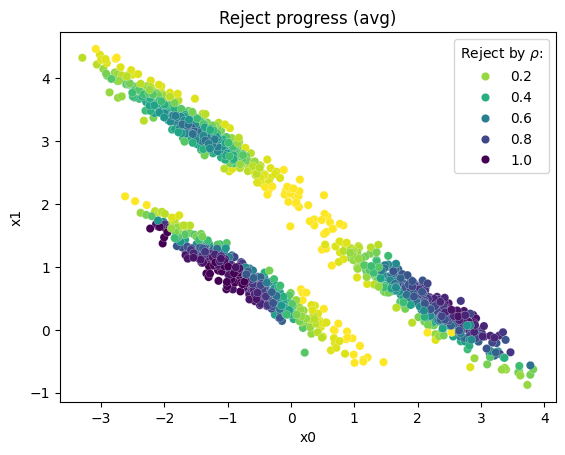

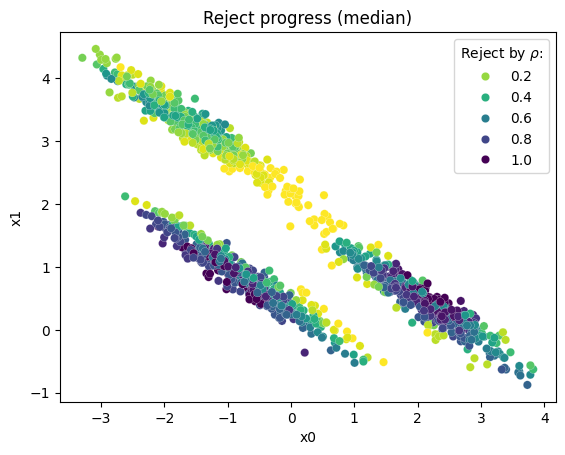

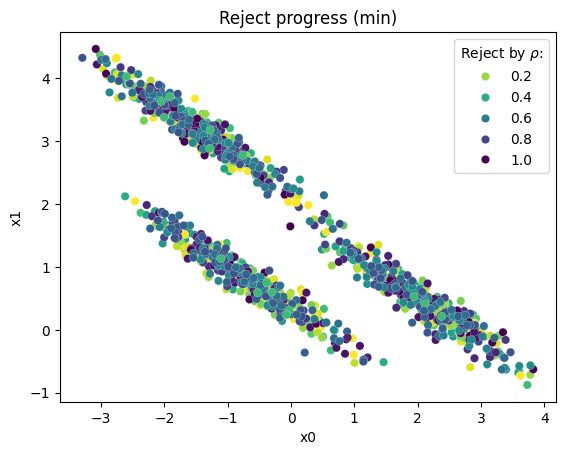

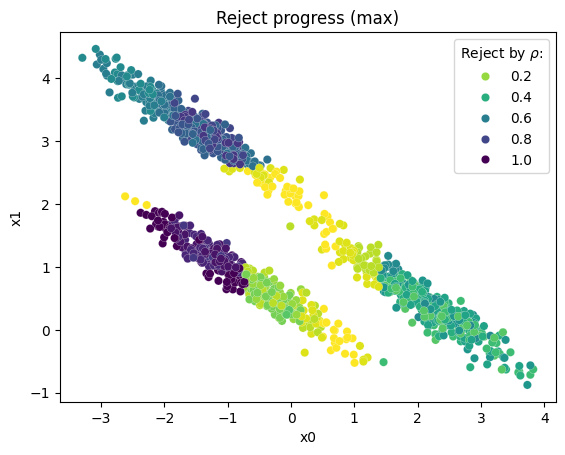

In [45]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste.sort_index(ascending=False), x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

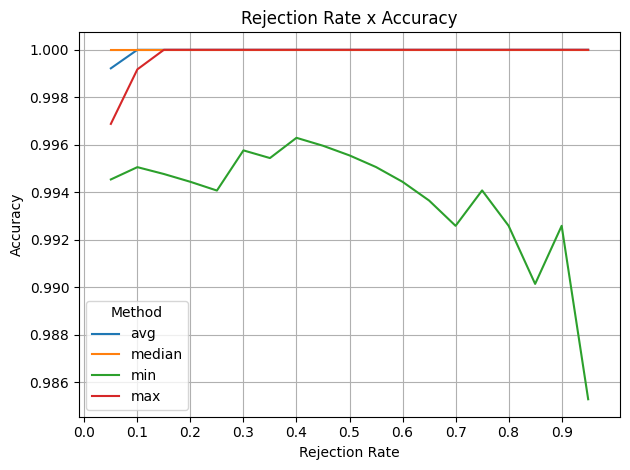

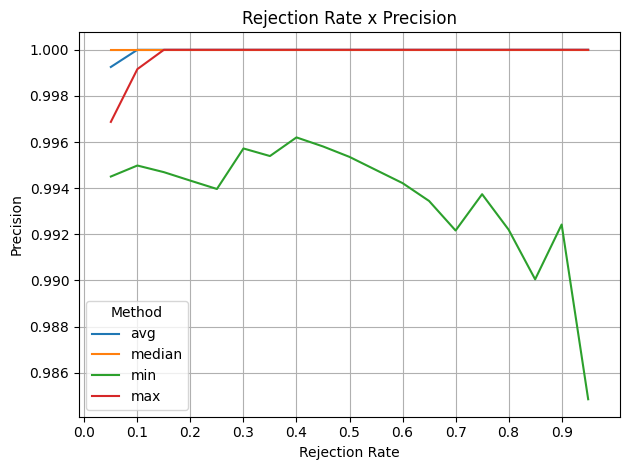

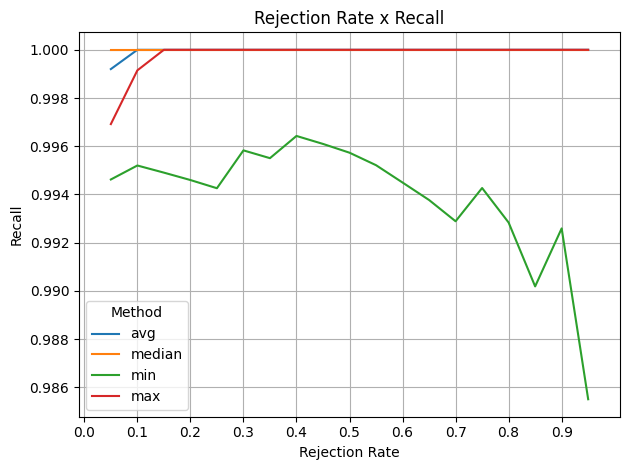

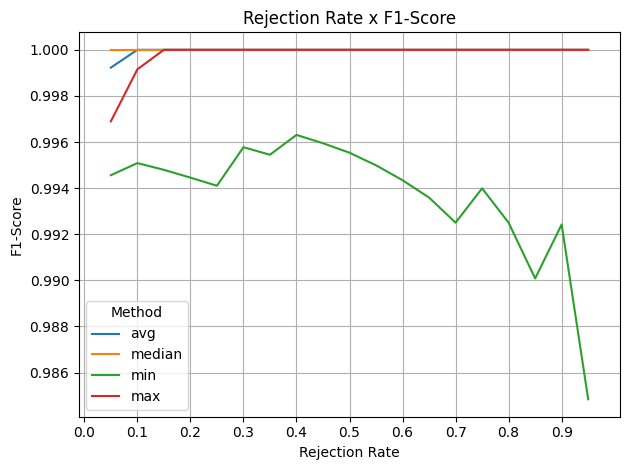

In [46]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [47]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.900
Method: median 	 |  Score: 0.900
Method: min 	 |  Score: 0.895
Method: max 	 |  Score: 0.900


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.999221   0.999256  0.999201  0.999227  0.899981
1     avg            0.10  1.000000   1.000000  1.000000  1.000000  0.899981
2     avg            0.15  1.000000   1.000000  1.000000  1.000000  0.899981
3     avg            0.20  1.000000   1.000000  1.000000  1.000000  0.899981
4     avg            0.25  1.000000   1.000000  1.000000  1.000000  0.899981
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  1.000000   1.000000  1.000000  1.000000  0.899881
72    max            0.80  1.000000   1.000000  1.000000  1.000000  0.899881
73    max            0.85  1.000000   1.000000  1.000000  1.000000  0.899881
74    max            0.90  1.000000   1.000000  1.000000  1.000000  0.899881
75    max            0.95  1.000000   1.000000  1.000000  1.000000  0.899881

[76 rows x 7 columns]

In [48]:
results_log.to_csv('results/aniso_V0.csv')

# VARIED

In [49]:
experiment_name = getExpName('varied')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/490795491288700875', creation_time=1761103736232, experiment_id='490795491288700875', last_update_time=1761103736232, lifecycle_stage='active', name='varied_v0_1246495320', tags={}>

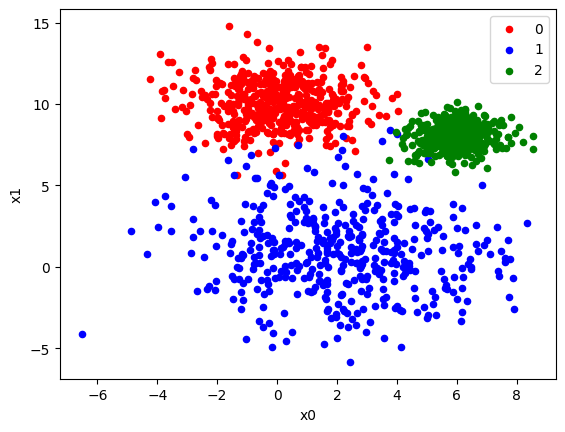

In [50]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('varied')

df = pd.DataFrame(dict(x0=X_test[:,0], x1=X_test[:,1], label=y_test))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [51]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

fdb79607a21b42d4bb7aaf114eb3ce19


6bab82d09c164f2b82a93b73c286eb1d


d26f280620194c8da05758c5829a3c69


7527bb82a37943d88af622f5298b8359


085157f6ee704e1dbb0942945d7f9b62


0fd24467f3344a2d9d57264f5a635293


a5d0805fde454aec95c41f93526a3878


6a27ec2340cf4a469b5f4efc2e137ce3


9339ab909b794f63ac5b95dd75c035be


596d04e4d5224e15952eae9f1eb365b5


e987a23c57d846db852283c4a4030fad


537c5741a2834090a3ef3c5b1171c367


In [52]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [53]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test,
                                                 X_test_norm,
                                                 y_test,
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 80/80 [00:03<00:00, 23.52it/s, Method=max, Rate=1.00]   


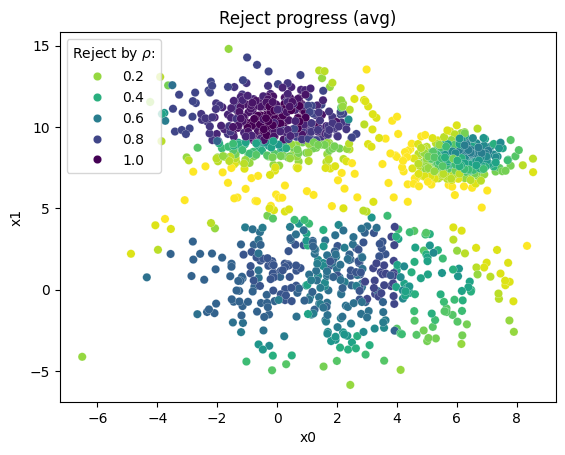

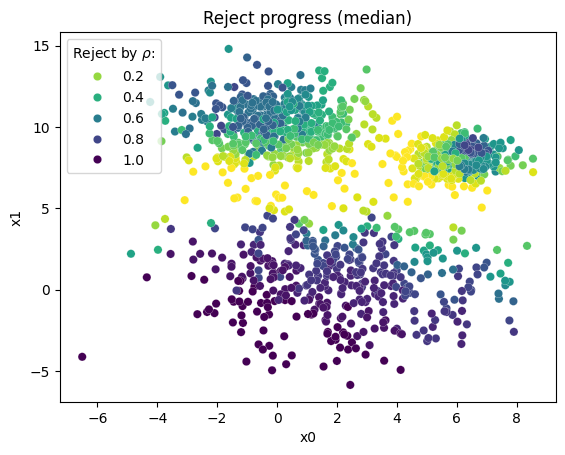

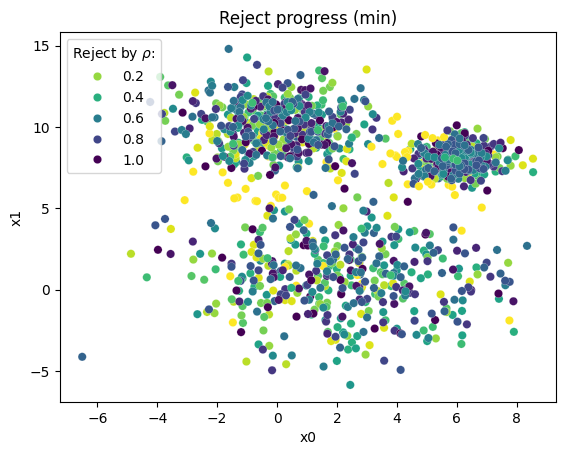

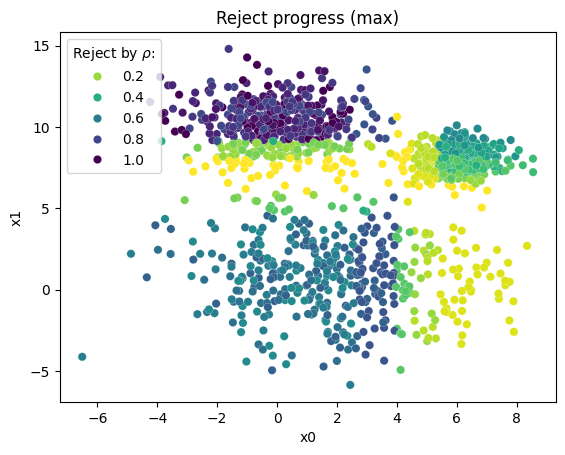

In [54]:
for method in ['avg','median','min','max']:
    teste = pd.concat([pd.DataFrame(X_test), pd.Series(y_test), reject_history[reject_history['Method']==method].set_index('idx').drop(columns=['Method'])], axis=1)
    teste.columns = ['x0','x1','y','Reject Rate']
    plt.title(f'Reject progress ({method})')
    sns.scatterplot(teste.sort_index(ascending=False), x='x0', y='x1', hue='Reject Rate', palette=color_palette, legend='brief', linewidth=0.15)
    plt.legend(title=r'Reject by $\rho$:')
    plt.show()

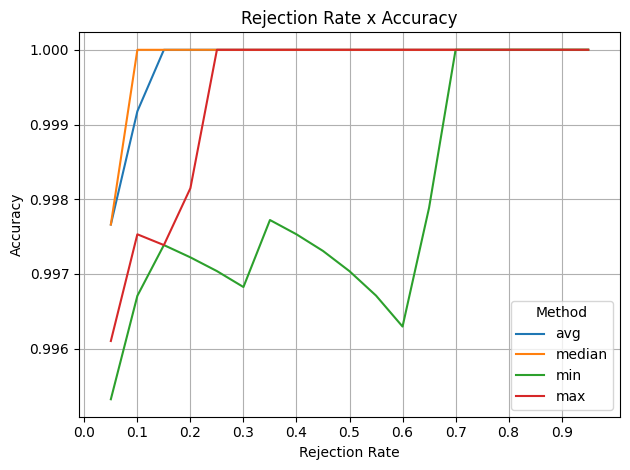

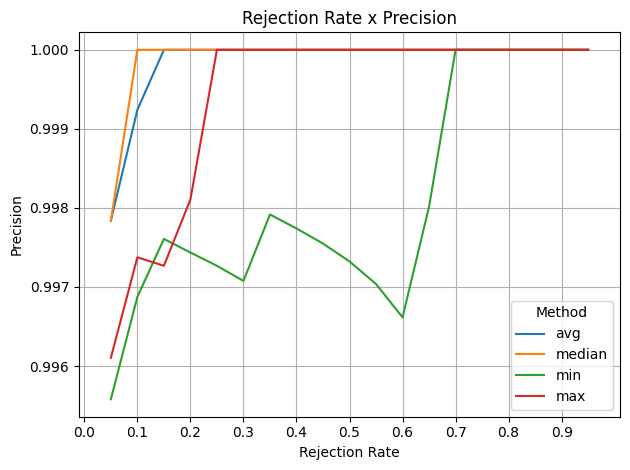

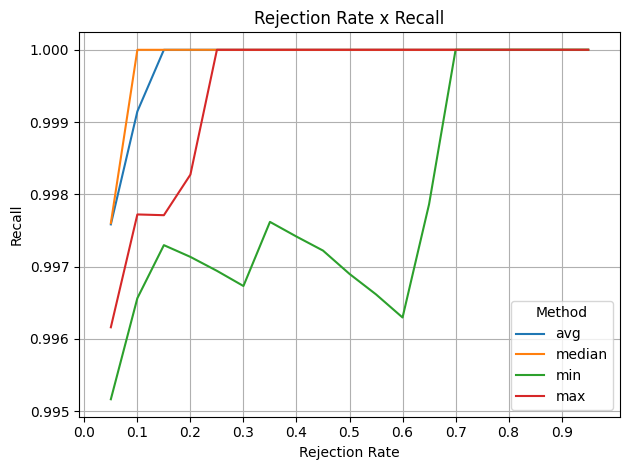

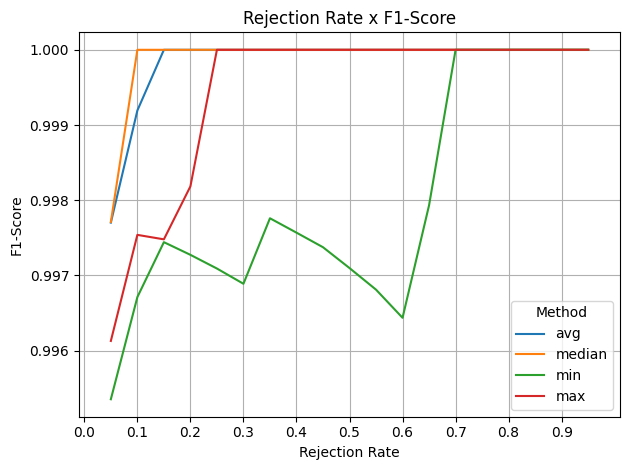

In [55]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [56]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.900
Method: median 	 |  Score: 0.900
Method: min 	 |  Score: 0.898
Method: max 	 |  Score: 0.900


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.997662   0.997835  0.997585  0.997702  0.899900
1     avg            0.10  0.999177   0.999241  0.999147  0.999193  0.899900
2     avg            0.15  1.000000   1.000000  1.000000  1.000000  0.899900
3     avg            0.20  1.000000   1.000000  1.000000  1.000000  0.899900
4     avg            0.25  1.000000   1.000000  1.000000  1.000000  0.899900
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  1.000000   1.000000  1.000000  1.000000  0.899556
72    max            0.80  1.000000   1.000000  1.000000  1.000000  0.899556
73    max            0.85  1.000000   1.000000  1.000000  1.000000  0.899556
74    max            0.90  1.000000   1.000000  1.000000  1.000000  0.899556
75    max            0.95  1.000000   1.000000  1.000000  1.000000  0.899556

[76 rows x 7 columns]

In [57]:
results_log.to_csv('results/varied_V0.csv')

# COVID

In [9]:
experiment_name = getExpName('covid')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/262086712618131218', creation_time=1761107075573, experiment_id='262086712618131218', last_update_time=1761107075573, lifecycle_stage='active', name='covid_v0_1246495320', tags={}>

In [10]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('covid')

In [11]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

e9bdcf0f24f0493898797ba032ef95a9


108749e8c7aa4b66b14cd4a3e3a8fc1c


3fe4cc72fa2c48079e6af88e2ffcb306


e19c65c06a064fada98ba45626d72def


2849ae3123d9454985aeddd5192ec031


39845389dfca454dab3e0bc99a5c770e


e9cc9af041d4419fb374665ebbbc293d


e82de45548d6461282f51a4bf4d10a40


cfe69616d098401ebc491e58fd83c744


25a3420867b6485e8466a54e9e144865


8207d0ce891f41c6b28fb888e9efd079


bb515af9496c4a0fbd23fe7aa3514459


In [12]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [13]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test.values,
                                                 X_test_norm.values,
                                                 y_test.values,
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 80/80 [00:01<00:00, 74.03it/s, Method=max, Rate=1.00]   


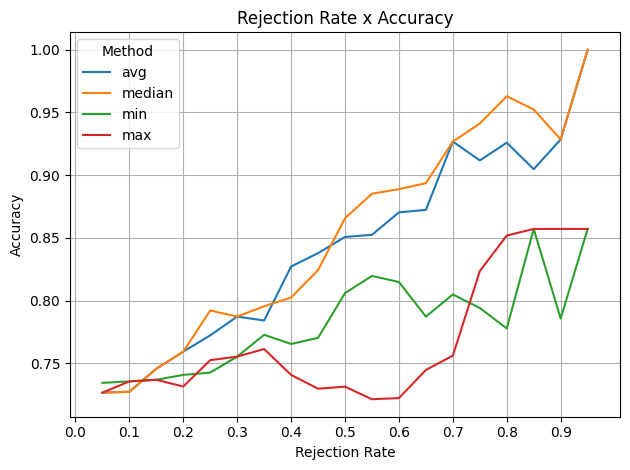

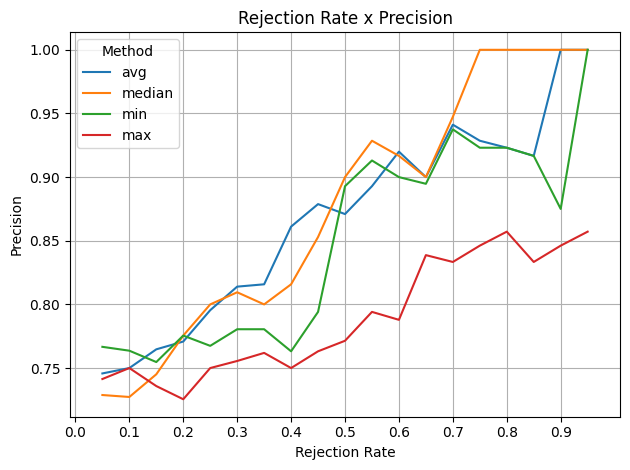

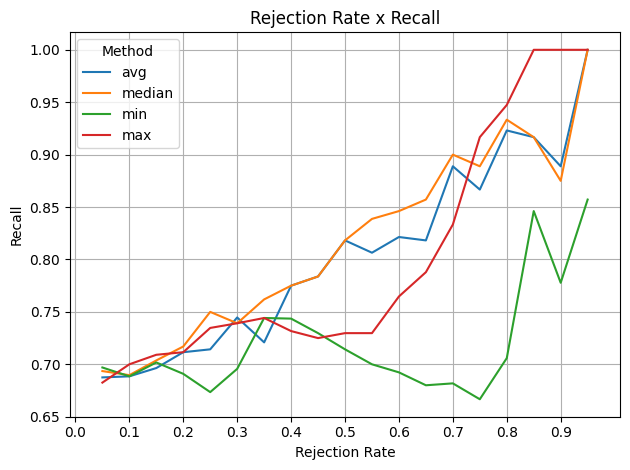

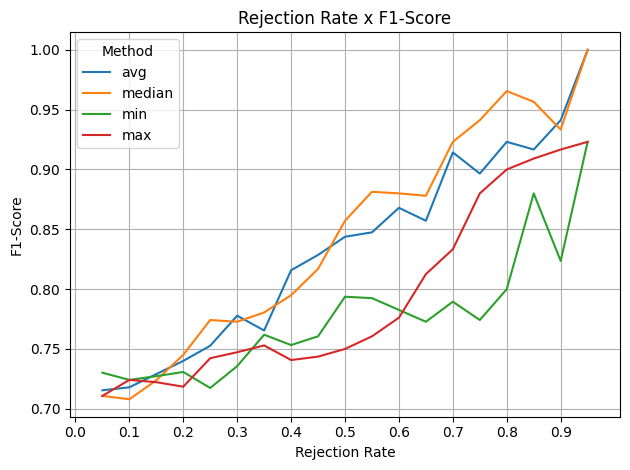

In [14]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [15]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.757
Method: median 	 |  Score: 0.767
Method: min 	 |  Score: 0.703
Method: max 	 |  Score: 0.690


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.726562   0.745763  0.687500  0.715447  0.757390
1     avg            0.10  0.727273   0.750000  0.688525  0.717949  0.757390
2     avg            0.15  0.745614   0.764706  0.696429  0.728972  0.757390
3     avg            0.20  0.759259   0.770833  0.711538  0.740000  0.757390
4     avg            0.25  0.772277   0.795455  0.714286  0.752688  0.757390
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  0.823529   0.846154  0.916667  0.880000  0.690033
72    max            0.80  0.851852   0.857143  0.947368  0.900000  0.690033
73    max            0.85  0.857143   0.833333  1.000000  0.909091  0.690033
74    max            0.90  0.857143   0.846154  1.000000  0.916667  0.690033
75    max            0.95  0.857143   0.857143  1.000000  0.923077  0.690033

[76 rows x 7 columns]

In [16]:
results_log.to_csv('results/covid_V0.csv')

# INADIPLENCE

In [9]:
experiment_name = getExpName('inadiplence')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/461088419596622674', creation_time=1761658299321, experiment_id='461088419596622674', last_update_time=1761658299321, lifecycle_stage='active', name='inadiplence_v0_1246495320', tags={}>

In [10]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('inadiplence')

In [11]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

18b570d409db4b1a95557934947441e6


077ab24b1bab485bb58794f065fa462c


eb62ca1c1da44a08b817a56c18bc740c


0926d79d9a984ce2a9d0a78e75ddaaaa


e27633cdda5e48b394afd92dbc24ea13


01861073e5d741b78113fe32e1f1fcca

64212bd47513432b8f668eb268569dbd

f38c388bddab4557be61b76e99157354


18d2b98893e642829a94017e55c1e30a


76494189a57a4bc695afd4f10d9ff2ba


25628e6ac3b043908664d6b5d23e0fc6


9762eb5b9f664b6791f00dc7be341677


In [12]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [15]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test.values,
                                                 X_test_norm,
                                                 y_test.values,
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing:   0%|          | 0/80 [00:00<?, ?it/s]

Processing: 100%|██████████| 80/80 [00:09<00:00,  8.62it/s, Method=max, Rate=1.00]   


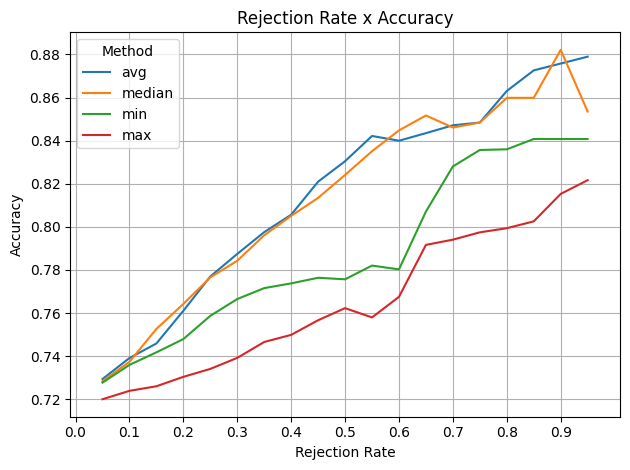

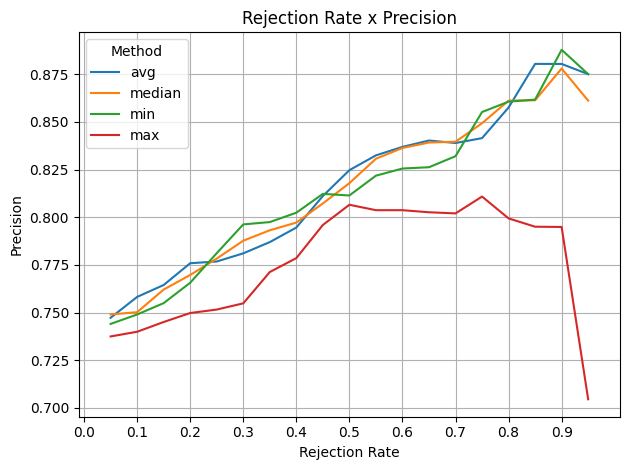

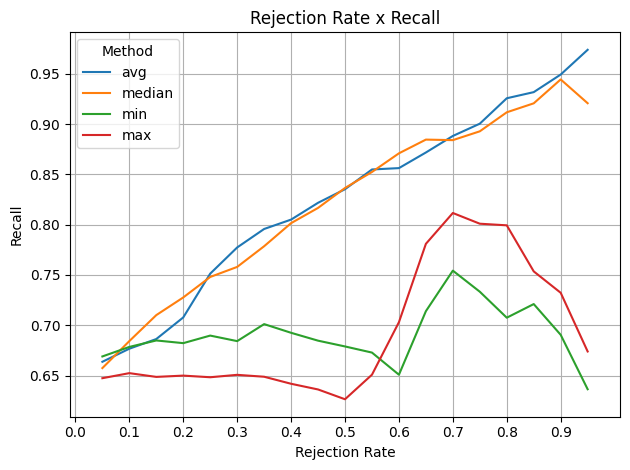

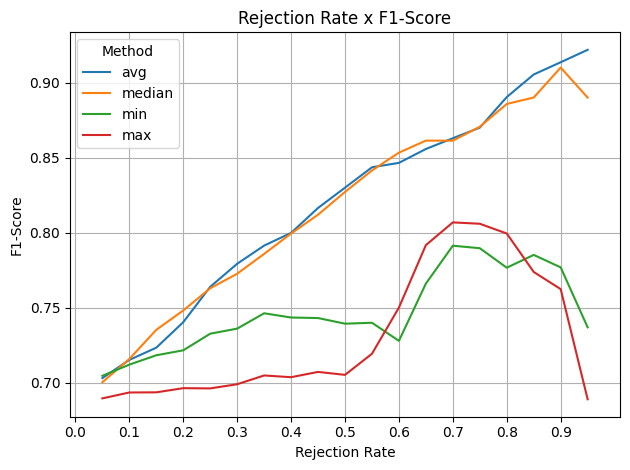

In [16]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [17]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.735
Method: median 	 |  Score: 0.734
Method: min 	 |  Score: 0.709
Method: max 	 |  Score: 0.688


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.729376   0.747261  0.663655  0.702981  0.735095
1     avg            0.10  0.739115   0.758197  0.676664  0.715114  0.735095
2     avg            0.15  0.745877   0.764452  0.686290  0.723265  0.735095
3     avg            0.20  0.761051   0.775862  0.707781  0.740260  0.735095
4     avg            0.25  0.776975   0.776761  0.751327  0.763833  0.735095
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  0.797452   0.810811  0.800971  0.805861  0.688278
72    max            0.80  0.799363   0.799363  0.799363  0.799363  0.688278
73    max            0.85  0.802548   0.795000  0.753555  0.773723  0.688278
74    max            0.90  0.815287   0.794872  0.732283  0.762295  0.688278
75    max            0.95  0.821656   0.704545  0.673913  0.688889  0.688278

[76 rows x 7 columns]

In [18]:
results_log.to_csv('results/inadiplence_V0.csv')

# CHURN

In [11]:
experiment_name = getExpName('churn')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/129108370531805597', creation_time=1761852617506, experiment_id='129108370531805597', last_update_time=1761852617506, lifecycle_stage='active', name='churn_v0_1246495320', tags={}>

In [13]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('churn')

In [14]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

d9d99625feef40979cd7e0986ab2658a


54758fb633d144738ba136fb750b6695


029c91c2ff8a409ca045f5cff641dd24


37e4ecb7e82d48638dc6fe3d74040584


8d8d4b9d491a4e53993f9b9d129529c7


a479a9cc412440c8821c819a63438f19


d250f4bd4ba941a3a23fb13c344e678e


a3ea0a679a3e4bbf97f447dc0bc478b4


90bbda89de8643c78fcbc1679e266f45


a39ea84f3a6b46358f366d631ccdbe06


fe9b97fbcda64c9badf8f29b571c8fd8


a7d7d56061904cd79483e5eb0756051b


In [15]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [16]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test.values,
                                                 X_test_norm.values,
                                                 y_test.values,
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing: 100%|██████████| 80/80 [00:05<00:00, 14.15it/s, Method=max, Rate=1.00]   


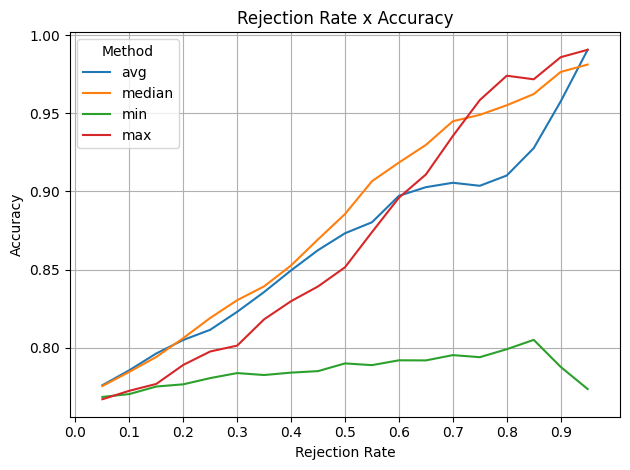

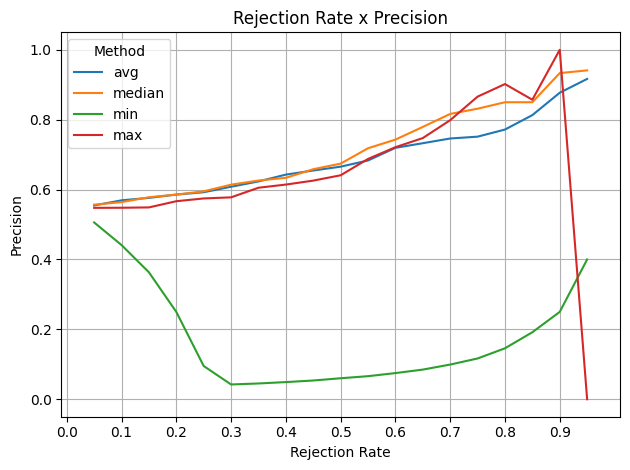

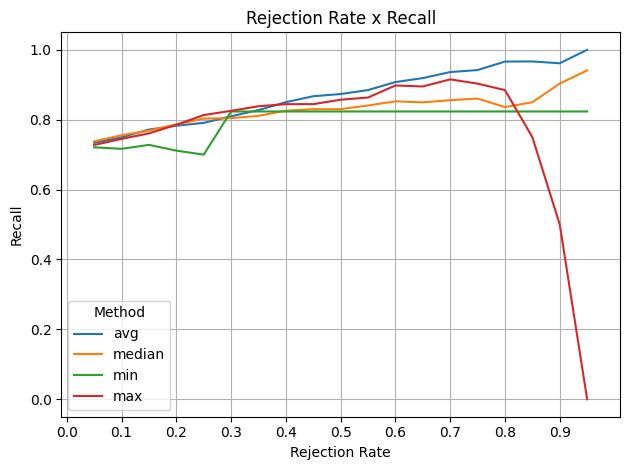

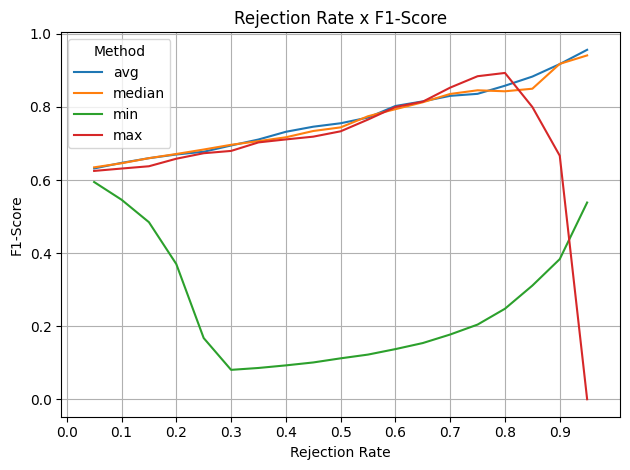

In [17]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [18]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.781
Method: median 	 |  Score: 0.795
Method: min 	 |  Score: 0.708
Method: max 	 |  Score: 0.783


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.776008   0.554598  0.733840  0.631751  0.780501
1     avg            0.10  0.785602   0.569254  0.749499  0.647059  0.780501
2     avg            0.15  0.796327   0.576299  0.771739  0.659851  0.780501
3     avg            0.20  0.804965   0.585664  0.782710  0.670000  0.780501
4     avg            0.25  0.811475   0.592453  0.790932  0.677454  0.780501
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  0.958412   0.865979  0.903226  0.884211  0.783043
72    max            0.80  0.973995   0.901961  0.884615  0.893204  0.783043
73    max            0.85  0.971698   0.857143  0.750000  0.800000  0.783043
74    max            0.90  0.985849   1.000000  0.500000  0.666667  0.783043
75    max            0.95  0.990566   0.000000  0.000000  0.000000  0.783043

[76 rows x 7 columns]

In [19]:
results_log.to_csv('results/churn_V0.csv')

# COVER TYPE

In [10]:
experiment_name = getExpName('covertype')
mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/pbsl/pog/IC%20-%20Reject%20Option/mlruns/935375239846274903', creation_time=1761872433142, experiment_id='935375239846274903', last_update_time=1761872433142, lifecycle_stage='active', name='covertype_v0_1246495320', tags={}>

In [12]:
X_train, X_train_norm, X_test, X_test_norm, y_train, y_test = get_data('covertype')

In [13]:
models = load_all_models(experiment_name, CONFIG['BASE_MODELS'])

8783a898dbbd4fbda980e02a16929005


369ffc68797e49aeb5b7a9da1a84089a


e4117a97e0934eadb5069a33baceecc1


6094d17991a84fc787c1234cf035c3a6


8d26b547463a483a96e33871ed9738f8


852ec4f9feca4f59b60d622e1ecae8fb


c5f1c15d8f2a4ef5b09252cae4d5dc4d


d15964ca77fa4e68b672feadc1c04695


2f4e64d174ba4742857f1673d0059414


ea156b8e33d84b2ea2eb31ccff61bf08


b52f2e0486724b6fba4449821bcbd5d6


62a2e5512b524ae9806b704e327fe36e


In [14]:
modelPool = Pool(models)
pred_reject = Rejector(modelPool)

In [15]:
results_log, reject_history = rejection_overhall(pred_reject, 
                                                 X_test.values,
                                                 X_test_norm.values,
                                                 y_test.values,
                                                 rej_rates=np.array(range(5,96,5))*0.01,
                                                 methods=['avg','median','min','max'])

Processing:   0%|          | 0/80 [00:00<?, ?it/s]

Processing: 100%|██████████| 80/80 [01:44<00:00,  1.30s/it, Method=max, Rate=1.00]   


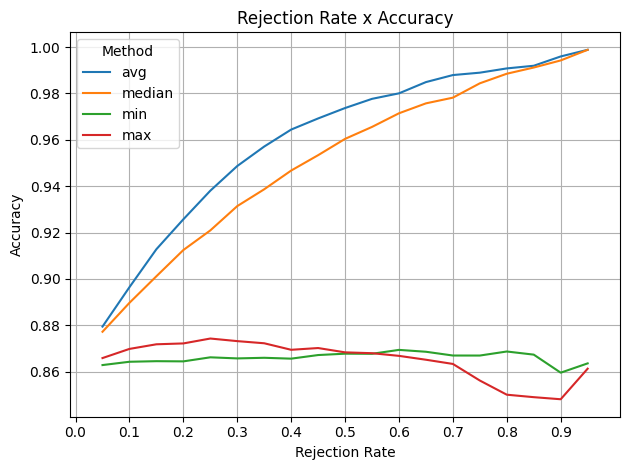

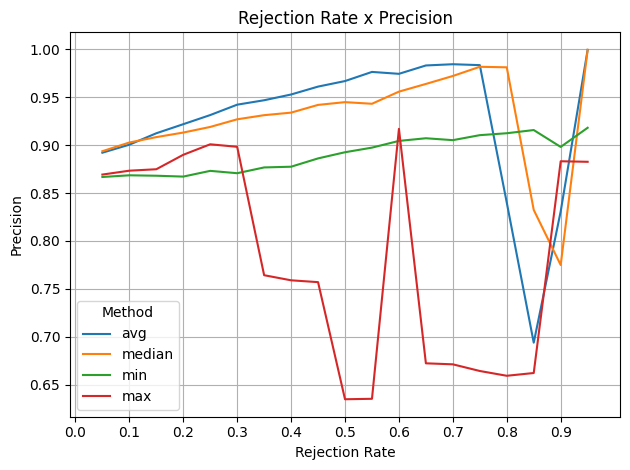

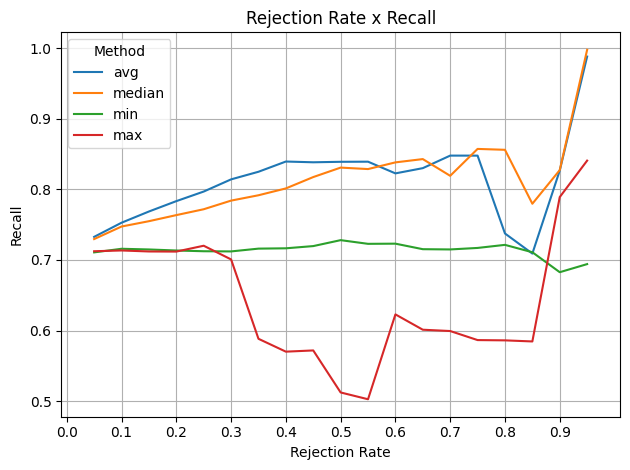

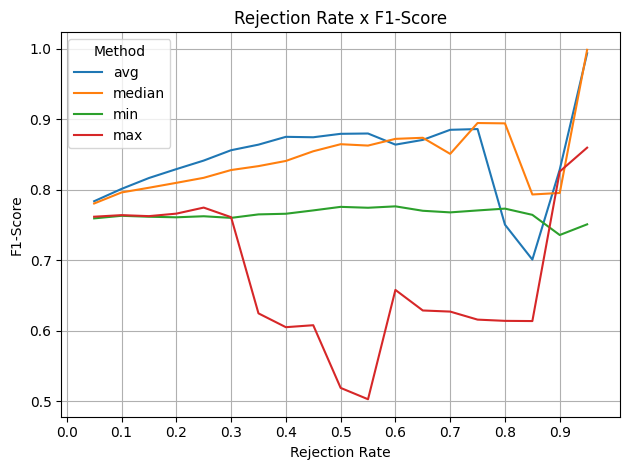

In [16]:
xticks = np.array(range(0,10))*0.1
for metric in ['Accuracy','Precision','Recall','F1-Score']:
    plt.title(f'Rejection Rate x {metric}')
    plt.xlim([-0.01,1.01])
    sns.lineplot(results_log, x='Rejection Rate', y=metric, hue='Method', )
    plt.xticks(xticks)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [17]:
for method in ['avg','median','min','max']:
    score = auc(x=np.array(range(5,96,5))*0.01,y=results_log.loc[results_log['Method']==method, 'Accuracy'])
    results_log.loc[results_log['Method']==method,'AU-ARC'] = score
    print(f'Method: {method} \t |  Score: {score:.3f}')
    
results_log

Method: avg 	 |  Score: 0.866
Method: median 	 |  Score: 0.857
Method: min 	 |  Score: 0.779
Method: max 	 |  Score: 0.779


Method  Rejection Rate  Accuracy  Precision    Recall  F1-Score    AU-ARC
0     avg            0.05  0.879408   0.892159  0.732762  0.783718  0.866185
1     avg            0.10  0.896418   0.900563  0.752784  0.801209  0.866185
2     avg            0.15  0.912803   0.912474  0.768668  0.816665  0.866185
3     avg            0.20  0.925708   0.921951  0.783347  0.829272  0.866185
4     avg            0.25  0.938045   0.931498  0.796919  0.841421  0.866185
..    ...             ...       ...        ...       ...       ...       ...
71    max            0.75  0.856127   0.664124  0.586586  0.615666  0.778544
72    max            0.80  0.850014   0.659130  0.586189  0.613917  0.778544
73    max            0.85  0.848948   0.662013  0.584647  0.613628  0.778544
74    max            0.90  0.848050   0.883229  0.789103  0.825877  0.778544
75    max            0.95  0.861239   0.882671  0.840724  0.859743  0.778544

[76 rows x 7 columns]

In [19]:
results_log.to_csv('results/covertype_V0.csv')